# A benchmark for the bayesian inversion of coefficients in PDEs

This notebook implements the benchmark problem described in "A BENCHMARK FOR THE BAYESIAN INVERSION OF COEFFICIENTS IN PARTIAL DIFFERENTIAL EQUATIONS, D. Aristoff and W. Bangerth" in the hIPPYlib-MUQ framework.

The purpose of the code written in this notebook is to explore the posterior defined as
$$
\pi_\text{post}(\boldsymbol{\theta} | \hat{\mathbf{z}}) \propto L ( \hat{\mathbf{z}} | \boldsymbol{\theta}) \pi_\text{pr} (\boldsymbol{\theta})
$$

where $\boldsymbol{\theta} \in \mathbb{R}^{64}$ is piecewise constant values of a parameter field $a(\mathbf{x})$ on a uniform $8 \times 8$ grid of the problem domain $\Omega = (0,1)^2$ (as shown below), and $\hat{\mathbf{z}} \in \mathbb{R}^{169}$ is measurements of a state field $u(\mathbf{x})$ at uniform $13 \times 13$ grid points (as show below). 
![images/locations_theta_zhat.png](images/locations_theta_zhat.png)

The parameter field $a$ and the state field $u$ are related through the two-dimensional Poisson equation:
$$
\begin{align*}
- \nabla \cdot [a(\mathbf{x}) \nabla u (\mathbf{x})] &= f(\mathbf{x}) \quad \text{in } \Omega,\\
u(\mathbf{x}) &= 0 \quad \text{on } \partial \Omega.
\end{align*}
$$
Here, the forcing function $f$ is taken to be constant as $f(\mathbf{x}) = 10$.


The observation data $\hat{\mathbf{z}}$ are created by solving the forward PDE with a parameter field described in the papaer using a 256 X 256 mesh and a bicubic finite element and then by applying a measurement operator to the state solution; see the paper.

To ensure positiveness of $\boldsymbol{\theta}$ (and also because the parameter has values over vast ranges in practical problems), we use the logarithm of the parameter vector, $\mathbf{m}$, for the inference:
$$
\boldsymbol{\theta} = \exp (\mathbf{m}).
$$
The corresponding posterior is
$$
\bar{\pi}_\text{post}(\mathbf{m} | \hat{\mathbf{z}}) \propto \bar{L} ( \hat{\mathbf{z}} | \mathbf{m}) \bar{\pi}_\text{pr} (\mathbf{m}).
$$

Note that
$$
L ( \hat{\mathbf{z}} | \boldsymbol{\theta}) \pi_\text{pr} (\boldsymbol{\theta}) d \boldsymbol{\theta} =
\bar{L} ( \hat{\mathbf{z}} | \mathbf{m}) \bar{\pi}_\text{pr} (\mathbf{m}) d \mathbf{m}.
$$

## Load modules

In [1]:
import math

import yaml
import h5py
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

import dolfin as dl
from petsc4py import PETSc

import hippylib as hl
import muq.Modeling as mm
import muq.SamplingAlgorithms as ms
import hippylib2muq as hm

## Some modifications of classes for this problem

Some classes are modified such that we can implement exactly the same problem with the one in the paper.
The parameter space lives on a coarse mesh (8 X 8 grid; 64 square cells), but a refined mesh (32 X 32 grid) is used to descritize the forward PDE domain.
So here we define a mapping between these two spaces (DG elements on 8 X 8 grid and on 32 X 32 grid) in `hl.PDEVariationalProblem` and modify `hl.Model` such that the mapping works properly in solving the forward and the adjoint, and evaluating the gradient and the Hessian action.

In [2]:
class PDEVariationalProblem(hl.PDEVariationalProblem):
    """Inherited from `hl.PDEVariationalProblem, this class takes care of mapping the parameter vector from
    a coarse mesh (self.Vh0) to a refined mesh (self.Vh[hl.PARAMETER]."""
    def __init__(self, Vh, varf_handler, bc, bc0):
        super().__init__(Vh, varf_handler, bc, bc0, is_fwd_linear=True)

        # original parameter space (defined on the coarse mesh)
        self.Vh0 = Vh[hl.PARAMETER]

        # parameter space is mapped to the refined mesh
        self.Vh = Vh.copy()
        self.Vh[hl.PARAMETER] = dl.FunctionSpace(self.Vh[hl.STATE].mesh(), "DG", 0)

        self._construct_parameter_projection()

    # Construct projection matrix from V0 to V1 (from the coarse to the refined).
    # Only consider DG = 0 space.
    def _construct_parameter_projection(self):
        V0 = self.Vh0
        V1 = self.Vh[hl.PARAMETER]
        assert (
            V0.ufl_element().is_cellwise_constant()
        ), "Parameter function space should be DG with order 0."

        dim0 = V0.dim()
        dim1 = V1.dim()
        M = np.zeros((dim1, dim0))

        tree = V0.mesh().bounding_box_tree()
        dof2coordinates = V1.tabulate_dof_coordinates()
        for i in range(dim1):
            px = dl.Point(dof2coordinates[i])
            cell = tree.compute_collisions(px)[0]
            dof_V0 = V0.dofmap().cell_dofs(cell)[0]

            M[i, dof_V0] = 1

        Msp = scipy.sparse.csr_matrix(M)
        self.M = dl.Matrix(
            dl.PETScMatrix(
                PETSc.Mat().createAIJWithArrays(
                    Msp.shape, (Msp.indptr, Msp.indices, Msp.data)
                )
            )
        )

    def parameter_projection(self, m0: dl.Vector, outfmt="vector"):
        """Project vector from Vh0 to Vh[hl.PARAMETER]

        :param outfmt: 'vector' or 'function'
        :type outfmt:
        :param m0: input vector
        :type m0: dl.Vector
        :return: output vector
        :rtype:
        """
        y = self.M * m0
        if outfmt == "function":
            return hl.vector2Function(y, self.Vh[hl.PARAMETER])
        elif outfmt == "vector":
            return y
        else:
            raise NotImplementedError("Given return format is not available.")

    def transmult_M(self, m1: dl.Vector, m0: dl.Vector):
        """Apply :math:`\\mathbf{M}^T` to vector

        :param m1: input vector in Vh[hl.PARAMETER] space
        :type m1: dl.Vector
        :param m0: output vector in Vh0 space
        :type m0: dl.Vector
        """
        self.M.transpmult(m1, m0)


class PointwiseStateObservation(hl.PointwiseStateObservation):
    def __init__(self, h, Vh, obs_points, noise_variance=None):
        self._construct_obs_matrix(h, Vh, obs_points)
        self.d = dl.Vector(self.B.mpi_comm())
        self.d.init(obs_points.shape[0])
        self.Bu = dl.Vector(self.B.mpi_comm())
        self.B.init_vector(self.Bu, 0)
        self.noise_variance = noise_variance

    def _construct_obs_matrix(self, h, Vh, obs_points):
        # Define characteristic function of unit square
        def heaviside(x):
            if x < 0:
                return 0
            else:
                return 1

        def S(x, y):
            return (
                heaviside(x)
                * heaviside(y)
                * (1 - heaviside(x - h))
                * (1 - heaviside(y - h))
            )

        # Define tent function
        def phi(x, y):
            return (
                (x + h) * (y + h) * S(x + h, y + h)
                + (h - x) * (h - y) * S(x, y)
                + (x + h) * (h - y) * S(x + h, y)
                + (h - x) * (y + h) * S(x, y + h)
            ) / h ** 2

        B = np.zeros((obs_points.shape[0], Vh.dim()))
        dof2coord = Vh.tabulate_dof_coordinates()
        for i in range(obs_points.shape[0]):
            xp = obs_points[i]
            for j in range(Vh.dim()):
                bx = xp - dof2coord[j]
                B[i, j] = phi(bx[0], bx[1])

        Bsp = scipy.sparse.csr_matrix(B)
        self.B = dl.Matrix(
            dl.PETScMatrix(
                PETSc.Mat().createAIJWithArrays(
                    Bsp.shape, (Bsp.indptr, Bsp.indices, Bsp.data)
                )
            )
        )


class Prior:
    def __init__(self, Vh, variance, mean=None):
        self.variance = variance

        u = dl.TrialFunction(Vh)
        v = dl.TestFunction(Vh)
        I = dl.assemble(dl.inner(u, v) * dl.dx)
        I.zero()
        I.ident_zeros()
        self.R = I / self.variance
        self.Rsolver = hl.PETScLUSolver(Vh.mesh().mpi_comm())
        self.Rsolver.set_operator(self.R)

        self.mean = mean
        if self.mean is None:
            self.mean = dl.Vector(self.R.mpi_comm())
            self.init_vector(self.mean, 0)

    def cost(self, m):
        d = self.mean.copy()
        d.axpy(-1.0, m)
        Rd = dl.Vector(self.R.mpi_comm())
        self.init_vector(Rd, 0)
        self.R.mult(d, Rd)
        return 0.5 * Rd.inner(d)

    def init_vector(self, x, ind):
        if ind == "noise":
            self.R.init_vector(x, 1)
            return

        self.R.init_vector(x, ind)

    def grad(self, m, out):
        d = m.copy()
        d.axpy(-1.0, self.mean)
        self.R.mult(d, out)

    def sample(self, noise, s, add_mean=True):
        rhs = noise
        self.Rsolver.solve(s, rhs)

        if add_mean:
            s.axpy(1.0, self.mean)


class Model(hl.Model):
    def generate_vector(self, component="ALL"):
        """
        By default, return the list :code:`[u,m,p]` where:
        
            - :code:`u` is any object that describes the state variable
            - :code:`m` is a :code:`dolfin.Vector` object that describes the parameter variable. \
            (Needs to support linear algebra operations)
            - :code:`p` is any object that describes the adjoint variable
        
        If :code:`component = STATE` return only :code:`u`
            
        If :code:`component = PARAMETER` return only :code:`m`
            
        If :code:`component = ADJOINT` return only :code:`p`
        """
        if component == "ALL":
            x = [
                self.problem.generate_state(),
                self.problem.generate_parameter(),
                self.problem.generate_state(),
            ]
        elif component == hl.STATE:
            x = self.problem.generate_state()
        elif component == hl.PARAMETER:
            # parameter function space defined on the coarse mesh
            x = dl.Function(self.problem.Vh0).vector()
        elif component == hl.ADJOINT:
            x = self.problem.generate_state()

        return x

    def solveFwd(self, out, x):
        """
        Solve the (possibly non-linear) forward problem.

        Parameters:

            - :code:`out`: is the solution of the forward problem (i.e. the state) (Output parameters)
            - :code:`x = [u,m,p]` provides

                1) the parameter variable :code:`m` for the solution of the forward problem
                2) the initial guess :code:`u` if the forward problem is non-linear

                .. note:: :code:`p` is not accessed.
        """
        self.n_fwd_solve = self.n_fwd_solve + 1
        m = self.problem.parameter_projection(x[hl.PARAMETER])
        self.problem.solveFwd(out, [x[hl.STATE], m, x[hl.ADJOINT]])

    def solveAdj(self, out, x):
        """
        Solve the linear adjoint problem.

        Parameters:

            - :code:`out`: is the solution of the adjoint problem (i.e. the adjoint :code:`p`) (Output parameter)
            - :code:`x = [u, m, p]` provides

                1) the parameter variable :code:`m` for assembling the adjoint operator
                2) the state variable :code:`u` for assembling the adjoint right hand side

                .. note:: :code:`p` is not accessed
        """
        self.n_adj_solve = self.n_adj_solve + 1
        rhs = self.problem.generate_state()
        m1 = self.problem.parameter_projection(x[hl.PARAMETER])
        x1 = [x[hl.STATE], m1, x[hl.ADJOINT]]
        self.misfit.grad(hl.STATE, x1, rhs)
        rhs *= -1.0
        self.problem.solveAdj(out, x1, rhs)

    def evalGradientParameter(self, x, mg, misfit_only=False):
        """
        Evaluate the gradient for the variational parameter equation at the point :code:`x=[u,m,p]`.

        Parameters:

            - :code:`x = [u,m,p]` the point at which to evaluate the gradient.
            - :code:`mg` the variational gradient :math:`(g, mtest)`, mtest being a test function in the parameter space \
            (Output parameter)
        
        Returns the norm of the gradient in the correct inner product :math:`g_norm = sqrt(g,g)`
        """
        tmp = self.generate_vector(hl.PARAMETER)

        m1 = self.problem.parameter_projection(x[hl.PARAMETER])
        mg1 = self.problem.generate_parameter()
        self.problem.evalGradientParameter([x[hl.STATE], m1, x[hl.ADJOINT]], mg1)
        self.problem.transmult_M(mg1, mg)

        self.misfit.grad(hl.PARAMETER, x, tmp)
        mg.axpy(1.0, tmp)
        if not misfit_only:
            self.prior.grad(x[hl.PARAMETER], tmp)
            mg.axpy(1.0, tmp)

        # self.prior.Msolver.solve(tmp, mg)
        return math.sqrt(mg.inner(mg))

    def setPointForHessianEvaluations(self, x, gauss_newton_approx=False):
        """
        Specify the point :code:`x = [u,m,p]` at which the Hessian operator (or the Gauss-Newton approximation)
        needs to be evaluated.

        Parameters:

            - :code:`x = [u,m,p]`: the point at which the Hessian or its Gauss-Newton approximation needs to be evaluated.
            - :code:`gauss_newton_approx (bool)`: whether to use Gauss-Newton approximation (default: use Newton)

        .. note:: This routine should either:

            - simply store a copy of x and evaluate action of blocks of the Hessian on the fly
            - or partially precompute the block of the hessian (if feasible)
        """
        self.gauss_newton_approx = gauss_newton_approx

        m1 = self.problem.parameter_projection(x[hl.PARAMETER])
        x1 = [x[hl.STATE], m1, x[hl.ADJOINT]]
        self.problem.setLinearizationPoint(x1, self.gauss_newton_approx)

        self.misfit.setLinearizationPoint(x, self.gauss_newton_approx)
        if hasattr(self.prior, "setLinearizationPoint"):
            self.prior.setLinearizationPoint(x[hl.PARAMETER], self.gauss_newton_approx)

    def applyC(self, dm, out):
        """
        Apply the :math:`C` block of the Hessian to a (incremental) parameter variable, i.e.
        :code:`out` = :math:`C dm`

        Parameters:

            - :code:`dm` the (incremental) parameter variable
            - :code:`out` the action of the :math:`C` block on :code:`dm`

        .. note:: This routine assumes that :code:`out` has the correct shape.
        """
        dm1 = self.problem.parameter_projection(dm)
        self.problem.apply_ij(hl.ADJOINT, hl.PARAMETER, dm1, out)

    def applyCt(self, dp, out):
        """
        Apply the transpose of the :math:`C` block of the Hessian to a (incremental) adjoint variable.
        :code:`out` = :math:`C^t dp`

        Parameters:

            - :code:`dp` the (incremental) adjoint variable
            - :code:`out` the action of the :math:`C^T` block on :code:`dp`

        ..note:: This routine assumes that :code:`out` has the correct shape.
        """
        out1 = self.problem.generate_parameter()
        self.problem.apply_ij(hl.PARAMETER, hl.ADJOINT, dp, out1)
        self.problem.transmult_M(out1, out)

    def applyWum(self, dm, out):
        """
        Apply the :math:`W_{um}` block of the Hessian to a (incremental) parameter variable.
        :code:`out` = :math:`W_{um} dm`

        Parameters:

            - :code:`dm` the (incremental) parameter variable
            - :code:`out` the action of the :math:`W_{um}` block on :code:`du`

        .. note:: This routine assumes that :code:`out` has the correct shape.
        """
        if self.gauss_newton_approx:
            out.zero()
        else:
            dm1 = self.problem.parameter_projection(dm)
            self.problem.apply_ij(hl.STATE, hl.PARAMETER, dm1, out)
            tmp = self.generate_vector(hl.STATE)
            self.misfit.apply_ij(hl.STATE, hl.PARAMETER, dm, tmp)
            out.axpy(1.0, tmp)

    def applyWmu(self, du, out):
        """
        Apply the :math:`W_{mu}` block of the Hessian to a (incremental) state variable.
        :code:`out` = :math:`W_{mu} du`

        Parameters:

            - :code:`du` the (incremental) state variable
            - :code:`out` the action of the :math:`W_{mu}` block on :code:`du`

        .. note:: This routine assumes that :code:`out` has the correct shape.
        """
        if self.gauss_newton_approx:
            out.zero()
        else:
            out1 = self.problem.generate_parameter()
            self.problem.apply_ij(hl.PARAMETER, hl.STATE, du, out1)
            self.problem.transmult_M(out1, out)

            tmp = self.generate_vector(hl.PARAMETER)
            self.misfit.apply_ij(hl.PARAMETER, hl.STATE, du, tmp)
            out.axpy(1.0, tmp)

    def applyWmm(self, dm, out):
        """
        Apply the :math:`W_{mm}` block of the Hessian to a (incremental) parameter variable.
        :code:`out` = :math:`W_{mm} dm`

        Parameters:

            - :code:`dm` the (incremental) parameter variable
            - :code:`out` the action of the :math:`W_{mm}` on block :code:`dm`

        .. note:: This routine assumes that :code:`out` has the correct shape.
        """
        if self.gauss_newton_approx:
            out.zero()
        else:
            dm1 = self.problem.parameter_projection(dm)
            out1 = self.problem.generate_parameter()
            self.problem.apply_ij(hl.PARAMETER, hl.PARAMETER, dm1, out1)
            self.problem.transmult_M(out1, out)

            tmp = self.generate_vector(hl.PARAMETER)
            self.misfit.apply_ij(hl.PARAMETER, hl.PARAMETER, dm, tmp)
            out.axpy(1.0, tmp)


## Set up miscellaneous things



In [3]:
# path to save all the results
results_path = "./results/"

# read observations
z_hat = np.loadtxt(
    "./obs.dat", delimiter=","
)

# read configuration parameters for mcmc
with open("./mcmc.yaml") as fid:
    inargs = yaml.full_load(fid)

## Set up the mesh and finite element spaces

In [4]:
nx = 32
nx_par = 8
mesh = dl.UnitSquareMesh.create(nx, nx, dl.CellType.Type.quadrilateral)
mesh_coarse = dl.UnitSquareMesh.create(nx_par, nx_par, dl.CellType.Type.quadrilateral)

Vh1 = dl.FunctionSpace(mesh, "CG", 1)
Vh0 = dl.FunctionSpace(mesh_coarse, "DG", 0)
Vh = [Vh1, Vh0, Vh1]

print(
    "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(
        Vh[hl.STATE].dim(), Vh[hl.PARAMETER].dim(), Vh[hl.ADJOINT].dim()
    )
)

Number of dofs: STATE=1089, PARAMETER=64, ADJOINT=1089


## Set up the forward problem

In [5]:
# The weak form of the forward PDE
def pde_varf(u, m, p):
    return (
        dl.exp(m) * dl.inner(dl.nabla_grad(u), dl.nabla_grad(p)) * dl.dx - f * p * dl.dx
    )

# Bounday of the problem domain
def boundary(x, on_boundary):
    return on_boundary

u0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hl.STATE], u0, boundary)
f = dl.Constant(10.0)

pde = PDEVariationalProblem(Vh, pde_varf, bc, bc)

## Set up the prior

The prior is assumed to be a Gaussian as
$$
\pi_\text{prior} (\mathbf{m}) \propto \exp \left\{ - \frac{\lVert \mathbf{m} - \mathbf{m}_0 \rVert^2}{2 \sigma^2}
\right\}.
$$

Here, we take $\sigma = 2$ and all entities of $\mathbf{m}_0$ equal to $\sigma^2$ (this setting is equivalent to the prior for $\boldsymbol{\theta}$ defined in the paper by Aristoff and Bangerth.

In [6]:
prior_std = 2
prior_variance = prior_std * prior_std
prior = Prior(Vh[hl.PARAMETER], prior_variance)
prior.mean[:] = np.ones(Vh[hl.PARAMETER].dim()) * prior_variance

## Read the measurement data and set up the likelihood

In [7]:
targets = np.zeros((169, 2))
k = 0
for i in range(1, 14):
    xp = i / (13.0 + 1.0)
    for j in range(1, 14):
        yp = j / (13.0 + 1.0)

        targets[k, 0] = xp
        targets[k, 1] = yp
        k += 1

misfit = PointwiseStateObservation(1.0 / nx, Vh[hl.STATE], targets)
misfit.d.set_local(z_hat)
noise_std_dev = 0.05
misfit.noise_variance = noise_std_dev * noise_std_dev

# Set up the model
model = Model(pde, prior, misfit)

#### Verify parameter-to-observable map

The cell below is just to verify the parameter-to-obervable map defined above.

"./testing/" directory contains ten files with 64-dimensional input vectors: Each of the files testing/input.X.txt contains a vector of coefficients (theta) for which the corresponding testing/output.X.z.txt contains the corresponding output at the evaluation points (the z vector that corresponds to the theta vector, as described in the paper linked to at the very top of this page)

We compare results obtained from our framework to these data.

In [8]:
def parm2obs(mvec, obs):
    uvec = pde.generate_state()
    m1 = pde.parameter_projection(mvec)
    pde.solveFwd(uvec, [uvec, m1, None])
    
    misfit.B.mult(uvec, obs)

mvec = dl.Function(pde.Vh0).vector()
obs = dl.Vector(misfit.B.mpi_comm())
misfit.B.init_vector(obs, 0)
for i in range(10):
    finput = "./testing/input.{}.txt".format(i)
    fzhat_refer = "./testing/output.{}.z.txt".format(i)
    mi = np.loadtxt(finput)
    zhat_refer = np.loadtxt(fzhat_refer)
    
    # Luckily, dof of mvec is ordered in the same way as how the input data is saved.
    mvec[:] = np.log(mi)
    parm2obs(mvec, obs)
    
    diff = zhat_refer - obs[:]
    print ("test {0}: || z-z_ref || = {1}".format(i, np.linalg.norm(diff)))

test 0: || z-z_ref || = 1.3841843658571482e-11
test 1: || z-z_ref || = 1.5877807529601092e-12
test 2: || z-z_ref || = 4.572917106515725e-13
test 3: || z-z_ref || = 4.530872767159667e-12
test 4: || z-z_ref || = 9.029945019471743e-12
test 5: || z-z_ref || = 3.0333470581086307e-12
test 6: || z-z_ref || = 1.1973672138819407e-11
test 7: || z-z_ref || = 5.359238945871938e-12
test 8: || z-z_ref || = 7.731528026865045e-12
test 9: || z-z_ref || = 3.983711246680051e-12


## Construct the Laplace approximation and its low-rank approximation

In [ ]:
#
# Compute the MAP point
#
m = prior.mean.copy()
solver = hl.ReducedSpaceNewtonCG(model)
solver.parameters["rel_tolerance"] = 1e-8
solver.parameters["abs_tolerance"] = 1e-12
solver.parameters["max_iter"] = 50
solver.parameters["GN_iter"] = 5
solver.parameters["globalization"] = "LS"
solver.parameters["LS"]["c_armijo"] = 1e-4

x = solver.solve([None, m, None])

if solver.converged:
    print("\nConverged in ", solver.it, " iterations.")
else:
    print("\nNot Converged")

print("Termination reason: ", solver.termination_reasons[solver.reason])
print("Final gradient norm: ", solver.final_grad_norm)
print("Final cost: ", solver.final_cost)


map = dl.Function(Vh[hl.PARAMETER], m)
dl.File(results_path + "map.pvd") << map


#
# Construct the low-rank based Laplace approximation of the posterior
#
model.setPointForHessianEvaluations(x, gauss_newton_approx=False)
Hmisfit = hl.ReducedHessian(model, misfit_only=True)
k = 64
p = 20

Omega = hl.MultiVector(x[hl.PARAMETER], k + p)
hl.parRandom.normal(1.0, Omega)
lmbda, V = hl.doublePassG(Hmisfit, prior.R, prior.Rsolver, Omega, k)

nu = hl.GaussianLRPosterior(prior, lmbda, V)
nu.mean = x[hl.PARAMETER]

plt.plot(range(0, k), lmbda, "b*", range(0, k + 1), np.ones(k + 1), "-r")
plt.yscale("log")
plt.xlabel("number")
plt.ylabel("eigenvalue")
plt.show()


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    1.888694e+03    1.808278e+03    8.041634e+01   -3.533696e+03   3.482989e+01   2.500000e-01   5.000000e-01
  2   1    9.255290e+02    8.230060e+02    1.025229e+02   -2.619487e+03   5.444668e+02   1.000000e+00   5.000000e-01
  3   1    5.544804e+02    4.587787e+02    9.570165e+01   -7.476007e+02   6.508708e+02   1.000000e+00   5.000000e-01
  4   2    4.805625e+02    3.912452e+02    8.931722e+01   -4.346523e+02   6.838760e+01   5.000000e-01   5.000000e-01
  5   1    4.116328e+02    3.177355e+02    9.389733e+01   -1.382988e+02   1.915990e+02   1.000000e+00   5.000000e-01
  6   2    4.033134e+02    3.100063e+02    9.330711e+01   -1.603526e+01   3.767678e+01   1.000000e+00   5.000000e-01
  7   2    3.950822e+02    3.000046e+02    9.507760e+01   -1.712886e+01   6.155370e+01   1.000000e+00   5.000000e-01
  8   2    3.880073e+02    2.935959e+02    9.441146e+01   -1.

In [17]:
import matplotlib.collections

#
# Ground truth parameter field
#
class ExactParameter(dl.UserExpression):
    def eval(self, value, x):
        if (x[0] >= 0.125 and x[0] <= 0.375) and (x[1] >= 0.125 and x[1] <= 0.375):
            value[0] = -2.3025850929940455
        elif (x[0] >= 0.625 and x[0] <= 0.875) and (x[1] >= 0.625 and x[1] <= 0.875):
            value[0] = 2.302585092994046
        else:
            value[0] = 0.0

def plot_dgelement_result(points, elements, values, title=None):
    """Plot the DG element results.
    points: x and y coordinates of cell vertices; [[x0, y0], ...]
    elements: connectivity of elements
    values: DG coefficient values
    """

    def quatplot(points, elements, values, ax=None, **kwargs):
        if not ax: 
            ax = plt.gca()
        vertices = points[elements]
        pc = matplotlib.collections.PolyCollection(vertices, **kwargs)
        pc.set_array(values)
        ax.add_collection(pc)
        ax.autoscale()
        return pc

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    pc = quatplot(points, np.asarray(elements), values, ax=ax, 
             edgecolor=None)
    fig.colorbar(pc, ax=ax)        
    
    if title:
        plt.title(title)

    plt.show()
    
cmesh_points = mesh_coarse.coordinates()
cmesh_conn_temp = mesh_coarse.cells()
cmesh_conn = cmesh_conn_temp.copy()
cmesh_conn[:,2] = cmesh_conn_temp[:,3]
cmesh_conn[:,3] = cmesh_conn_temp[:,2]

dofmap = Vh[hl.PARAMETER].dofmap()
parameter_dofs = []
for cell in dl.cells(Vh[hl.PARAMETER].mesh()):
    ind = cell.index()
    parameter_dofs.append(dofmap.cell_dofs(ind)[0])   

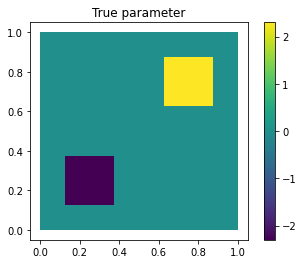

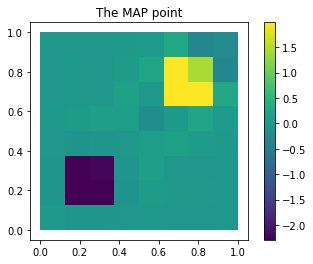

In [18]:
# Plot the ground truth parameter field
m = dl.interpolate(ExactParameter(), Vh[hl.PARAMETER])
mtrue_values = m.vector()[parameter_dofs]

plot_dgelement_result(cmesh_points, cmesh_conn, mtrue_values, "True parameter")

# Plot the MAP point
plot_dgelement_result(cmesh_points, cmesh_conn, map.vector()[:], "The MAP point")

## Exploring the posterior using MCMC methods

In [23]:
def setup_modpiece(prior, loglikelihood_model, method, dim):
    # a place holder ModPiece for the parameters
    idparam = mm.IdentityOperator(dim)

    # log Gaussian Prior ModPiece
    gaussprior = prior
    log_gaussprior = gaussprior.AsDensity()

    # parameter to log likelihood Modpiece
    param2likelihood = loglikelihood_model

    # log target ModPiece
    log_target = mm.DensityProduct(2)

    workgraph = mm.WorkGraph()

    # Identity operator for the parameters
    workgraph.AddNode(idparam, "Identity")

    # Prior model
    workgraph.AddNode(log_gaussprior, "Prior")

    # Likelihood model
    workgraph.AddNode(param2likelihood, "Param2Like")

    # Posterior
    workgraph.AddNode(log_target, "Target")

    workgraph.AddEdge("Identity", 0, "Prior", 0)
    workgraph.AddEdge("Prior", 0, "Target", 0)

    workgraph.AddEdge("Identity", 0, "Param2Like", 0)
    workgraph.AddEdge("Param2Like", 0, "Target", 1)

    # Enable caching
    if method not in ("pcn", "hpcn", ""):
        log_gaussprior.EnableCache()
        param2likelihood.EnableCache()

    # Construct the problem
    post_dens = workgraph.CreateModPiece("Target")
    problem = ms.SamplingProblem(post_dens)

    return problem


def generate_MHoptions(nburnin, nsamples, beta=0.0, tau=0.0):
    opts = dict()
    opts["BurnIn"] = nburnin
    opts["NumSamples"] = nsamples + nburnin
    opts["PrintLevel"] = 2
    opts["Beta"] = beta
    opts["StepSize"] = tau
    return opts


def setup_proposal(propName, options, problem, propGaussian):
    if propName == "pcn":
        proposal = ms.CrankNicolsonProposal(options, problem, propGaussian)
    elif propName == "mala":
        proposal = ms.MALAProposal(options, problem, propGaussian)
    else:
        raise NotImplementedError("Proposal is not availabe.")

    return proposal


def setup_kernel(kernName, options, problem, proposal):
    if kernName == "mh":
        kernel = ms.MHKernel(options, problem, proposal)
    else:
        raise NotImplementedError("Kernel is not availabe.")

    return kernel


def run_MCMC(options, kernel, startpoint):
    # Construct the MCMC sampler
    sampler = ms.SingleChainMCMC(options, [kernel])

    # Run the MCMC sampler
    samples = sampler.Run([startpoint])

    if "AcceptanceRate" in dir(kernel):
        return samples, kernel.AcceptanceRate(), sampler.TotalTime()
    elif "AcceptanceRates" in dir(kernel):
        return samples, kernel.AcceptanceRates(), sampler.TotalTime()


def generate_starting():
    noise = dl.Vector()
    nu.init_vector(noise, "noise")
    hl.parRandom.normal(1.0, noise)
    pr_s = model.generate_vector(hl.PARAMETER)
    post_s = model.generate_vector(hl.PARAMETER)
    nu.sample(noise, pr_s, post_s, add_mean=True)
    x0 = hm.dlVector2npArray(post_s)
    return x0


def generate_MCMCsamples(mcmc_parameters, fname=None):
    problem = setup_modpiece(
        mcmc_parameters["prior"],
        mcmc_parameters["likelihood_model"],
        mcmc_parameters["method"],
        Vh[hl.PARAMETER].dim(),
    )
    opts = generate_MHoptions(
        mcmc_parameters["burnin"],
        mcmc_parameters["nsamples"],
        beta=mcmc_parameters["beta"],
    )
    prop = setup_proposal(
        mcmc_parameters["proposal_name"],
        opts,
        problem,
        mcmc_parameters["proposal_gauss"],
    )
    kern = setup_kernel("mh", opts, problem, prop)

    m0 = generate_starting()
    samps, acceptrate, etime = run_MCMC(opts, kern, m0)
    if fname is not None:
        with h5py.File(fname + ".h5", "w") as fid:
            fid["/"].attrs["Beta"] = mcmc_parameters["beta"]
            fid["/samples"] = samps.AsMatrix()
            fid["/samples"].attrs["AR"] = acceptrate
            fid["/samples"].attrs["etime"] = etime
            # covariance = samps.Covariance()
            # fid["/covariance"] = covariance

In [34]:
# Set up ModPieces for implementing MCMC methods
mcmc_parameters = {}
mcmc_parameters["method"] = inargs["method"]
mcmc_parameters["nsamples"] = inargs["nsamples"]
mcmc_parameters["burnin"] = int(mcmc_parameters["nsamples"] * 0.05)
mcmc_parameters["beta"] = inargs["beta"]
mcmc_parameters["tau"] = 0.0
if mcmc_parameters["method"] == "hpcn":
    mcmc_parameters["proposal_name"] = "pcn"
else:
    raise NotImplementedError()
mcmc_parameters["proposal_gauss"] = hm.LAPosteriorGaussian(nu)
mcmc_parameters["prior"] = mm.Gaussian(
    prior.mean[:], prior.R.array(), mm.Gaussian.Mode.Precision
)
mcmc_parameters["likelihood_model"] = hm.Param2LogLikelihood(model)
generate_MCMCsamples(mcmc_parameters, fname=inargs["fname"])

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 46%
  20% Complete
    Block 0:
      Acceptance Rate = 36%
  30% Complete
    Block 0:
      Acceptance Rate = 35%
  40% Complete
    Block 0:
      Acceptance Rate = 32%
  50% Complete
    Block 0:
      Acceptance Rate = 29%
  60% Complete
    Block 0:
      Acceptance Rate = 26%
  70% Complete
    Block 0:
      Acceptance Rate = 25%
  80% Complete
    Block 0:
      Acceptance Rate = 23%
  90% Complete
    Block 0:
      Acceptance Rate = 22%
  100% Complete
    Block 0:
      Acceptance Rate = 22%
Completed in 16.9335 seconds.


NameError: name 'os' is not defined